# Project 3 - Reddit APIs & Classification (Modelling Section)

## Background

Reddit is a massive collection of forums where people share news and content or comment on other people’s posts. Reddit is broken up into more than a million communities known as “subreddits” and each of which covers a different topic.

## Problem Statement

There are posts related to Pytorch and Tensorflow which could be wrongly posted in subreddits having similar content, and might require the moderators of the subreddits to clean it up occassionally to ensure content relevancy for viewers.

In this project, I aim to develop classifier models and identify if a Naive Bayes classifer or another classifier model would be suitable in classifying if a reddit post belongs to the either Pytorch or Tensorflow subreddits which can be useful for the moderators in advising on posts that require cleanup.

## Executive Summary

The growing AI industry and the availability of open-sourced frameworks online such as the Tensorflow and Pytorch, the top 2 common frameworks used for implementing various neural network architecture by AI researchers, enthusiasts and application engineers has resulted in lots of questions and answers, especially in Reddit. 

As such there might be posts on Reddit site related to the two frameworks that could be wrongly posted in wrong subreddits. In view of the increasing amount of posts, it would be beneficial for subreddit stakeholders to have a classifier that helps to classify related posts/comments which are posted incorrectly in various subreddits as part of their cleanup process.

In this project, more than 900 unique reddit posts have been scraped from both Pytorch and Tensorflow subreddits respectively via Reddit's API, for the purpose of training classifier models which could potentially recommend Reddit moderators if a specific post should be moved to correct subreddit.

## Data dictionary

|Feature|Python data Type|Description|
|---|---|---|
|**created_utc**|*integer*|Time of created post in UTC value|
|**subreddit**|*integer*|Subreddit classification for the post (**Tensorflow - 1; Pytorch - 0**)|
|**selftext**|*string*|Subreddit post|
|**title**|*string*|Title of subreddit post|
|**title_text**|*integer*|String concatenation of title followed text|
|**lemma_title_text**|*integer*|Lemmatized content with stopwords removed from *title_text* column|
|**pstem_title_text**|*integer*|Stemmatized content and stopwords removed from *title_text* column|

# Modelling

## Import commonly used libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

## Read in csv

In [2]:
df = pd.read_csv("pytorch_tf_reddit_concat.csv")

**Consider experimenting with lemmatized title_text column as lemmatization is usually the more correct and precise way of handling things from a grammatical point of view.**

In [3]:
df.head()

,created_utc,subreddit,selftext,title,title_text,lemma_title_text,pstem_title_text
0,1.615279e+09,0,i have implemented resnet cnn from scatch in p...,resnet from scratch,resnet from scratch i have implemented resnet ...,resnet scratch implemented resnet cnn scatch p...,resnet scratch implement resnet cnn scatch pyt...
1,1.615313e+09,0,i have trained resnet https github com arjun m...,resnet vs resnet,resnet vs resnet i have trained resnet https g...,resnet v resnet trained resnet http com arjun ...,resnet vs resnet train resnet http com arjun m...
2,1.615205e+09,0,open neural network exchange onnx is a powerfu...,converting a model from pytorch to tensorflow ...,converting a model from pytorch to tensorflow ...,converting pytorch tensorflow guide onnx open ...,convert pytorch tensorflow guid onnx open neur...
3,1.615189e+09,0,hi i'm considering a swap from tf to pytorch b...,is there a flexible dataloader similar to tf d...,is there a flexible dataloader similar to tf d...,flexible dataloader similar tf data datasets h...,flexibl dataload similar tf data dataset hi i'...
4,1.615103e+09,0,i apologise in advanced for this newb question...,how to implement pre trained embeddings,how to implement pre trained embeddings i apol...,implement pre trained embeddings apologise adv...,implement pre train embed apologis advanc thi ...


In [4]:
# Specify column to be used as predictor and column as target 
X = df["lemma_title_text"]
y = df["subreddit"]

**Check subreddit representation proportion**

In [5]:
y.value_counts(normalize = True)

0    0.506717
1    0.493283
Name: subreddit, dtype: float64

**Apply train-test split**

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    random_state=42,
                                                    stratify=y)

## Vectorization

Consider applyng Vectorizer methods such as Count Vectorizer and TF-IDF to convert our training data into bag of words, so that models could be trained and be compared with these two methods.

### Count Vectorizer

In [7]:
cvec = CountVectorizer(analyzer = "word",
                     tokenizer = None,
                     preprocessor = None,
                     stop_words = None,
                     max_features = 500)

# Fit and transform the corpus which gives a sparse matrix
X_train_cv = cvec.fit_transform(X_train)

# Transform test
X_test_cv = cvec.transform(X_test)


### Term Frequency-Inverse Document Frequency (TF-IDF) vectorizer

In [8]:
tvec = TfidfVectorizer(analyzer = "word",
                     tokenizer = None,
                     preprocessor = None,
                     stop_words = None,
                     max_features = 500)

# Apply transforms to training and test data
X_train_idf = tvec.fit_transform(X_train)
X_test_idf = tvec.transform(X_test)

**Convert the above transformed data into dataframe for visualisation and analysis in later sections** 

In [9]:
X_train_cv_df = pd.DataFrame(X_train_cv.toarray(), columns=cvec.get_feature_names())
X_test_cv_df = pd.DataFrame(X_test_cv.toarray(), columns=cvec.get_feature_names())
X_train_idf_df = pd.DataFrame(X_train_idf.toarray(), columns=tvec.get_feature_names())
X_train_idf_df = pd.DataFrame(X_train_idf.toarray(), columns=tvec.get_feature_names())

#Convert series type to dataframe
test_data_df = y_test.to_frame()

## Modelling with classifiers
We use grid search to find best possible parameters for each model and comparing across all models. Random state is set at 42 for results reproducibility purposes

In [10]:
#Define a dictionary to store all the model performance
performance_dict = dict()
cmatrix_display_labels = ["Pytorch", "Tensorflow"]

### Naive Bayes classifier with Count Vectorizer

In [11]:
from sklearn.naive_bayes import BernoulliNB

**Find the best parameter with grid search**

In [12]:
nb_gs_cv = GridSearchCV(
    BernoulliNB(), 
    param_grid = {
        'alpha' : [0.001, 0.01, 0.1, 0.5, 1, 5, 10],
    },
    cv = 5)

nb_gs_cv.fit(X_train_cv, y_train)

#Get best param
nb_gs_cv.best_params_

{'alpha': 0.001}

**Fit the model with best parameter**

In [13]:
nb_cv = BernoulliNB(alpha = nb_gs_cv.best_params_["alpha"])
nb_cv.fit(X = X_train_cv,y = y_train)

# Save the model as pickel file
filename = 'models/NaiveBayes_CV_model.pkl'
pickle.dump(nb_cv, open(filename, 'wb'))

nb_cv_score = cross_val_score(nb_cv, X_train_cv, y_train, cv = 10).mean()
nb_cv_score

0.8179547790339157

In [14]:
# Evaluate model on testing data.
nb_test_score = nb_cv.score(X_test_cv, y_test)
nb_test_score

0.7553648068669528

In [15]:
performance_dict["Naive Bayes CountVec"] = [nb_cv_score,nb_test_score]

**Confusion matrix**

In [16]:
nb_predictions = nb_cv.predict(X_test_cv)
test_data_df["nb_cv"] = nb_predictions
tn, fp, fn, tp = confusion_matrix(y_test, nb_predictions).ravel()
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 209
False Positives: 27
False Negatives: 87
True Positives: 143


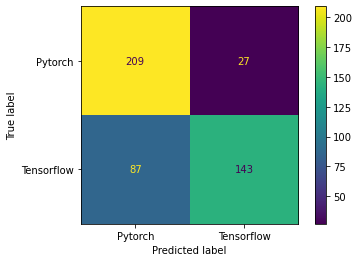

In [17]:
plot_confusion_matrix(nb_cv, X_test_cv, y_test, display_labels= cmatrix_display_labels);

**Naive Bayes Feature Importance**

In [18]:
#prob for Tensorflow class in descending order
tf_class_prob_sorted = nb_cv.feature_log_prob_[1, :].argsort()[::-1]
#prob for Pytorch class in descending order
pytorch_class_prob_sorted = nb_cv.feature_log_prob_[0, :].argsort()[::-1]

# Get a dictionary storing the top 10 feature importance and convert to dataframe
tf_top_feature_dict = {str(cvec.get_feature_names()[i]): nb_cv.feature_log_prob_[1, i] for i in tf_class_prob_sorted[:10]}
pytorch_top_feature_dict = {str(cvec.get_feature_names()[i]): nb_cv.feature_log_prob_[0, i] for i in pytorch_class_prob_sorted[:10]}

tf_top_feature_df = pd.DataFrame.from_dict(tf_top_feature_dict, orient = "index" , columns = ["log prob"])
pytorch_top_feature_df = pd.DataFrame.from_dict(pytorch_top_feature_dict, orient = "index" , columns = ["log prob"])

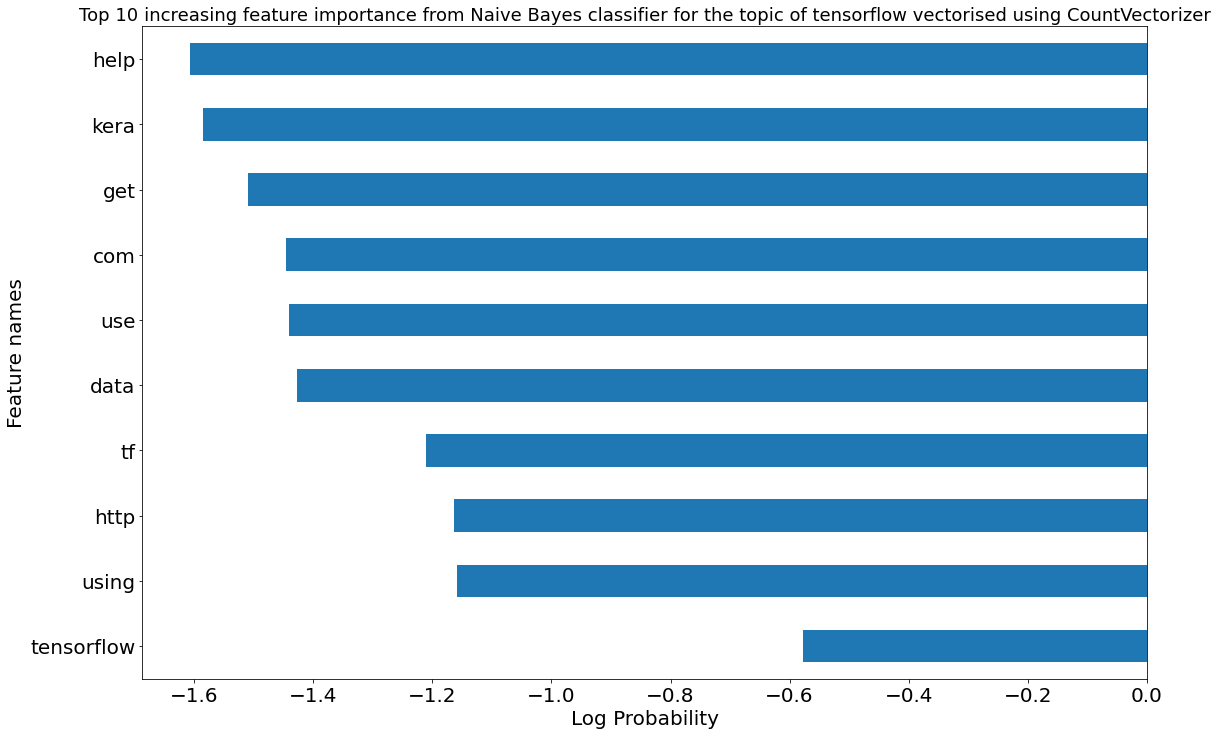

In [128]:
fig, ax = plt.subplots(figsize = (18,12))
tf_top_feature_df.plot(kind = "barh",
                       legend = False,
                       ax = ax
                );

ax.set_title("Top 10 increasing feature importance from Naive Bayes classifier for the topic of tensorflow vectorised using CountVectorizer", fontsize = 18);
ax.set_ylabel("Feature names", fontsize = 20);
ax.set_xlabel("Log Probability", fontsize = 20);
ax.tick_params(axis='both', labelsize=20)

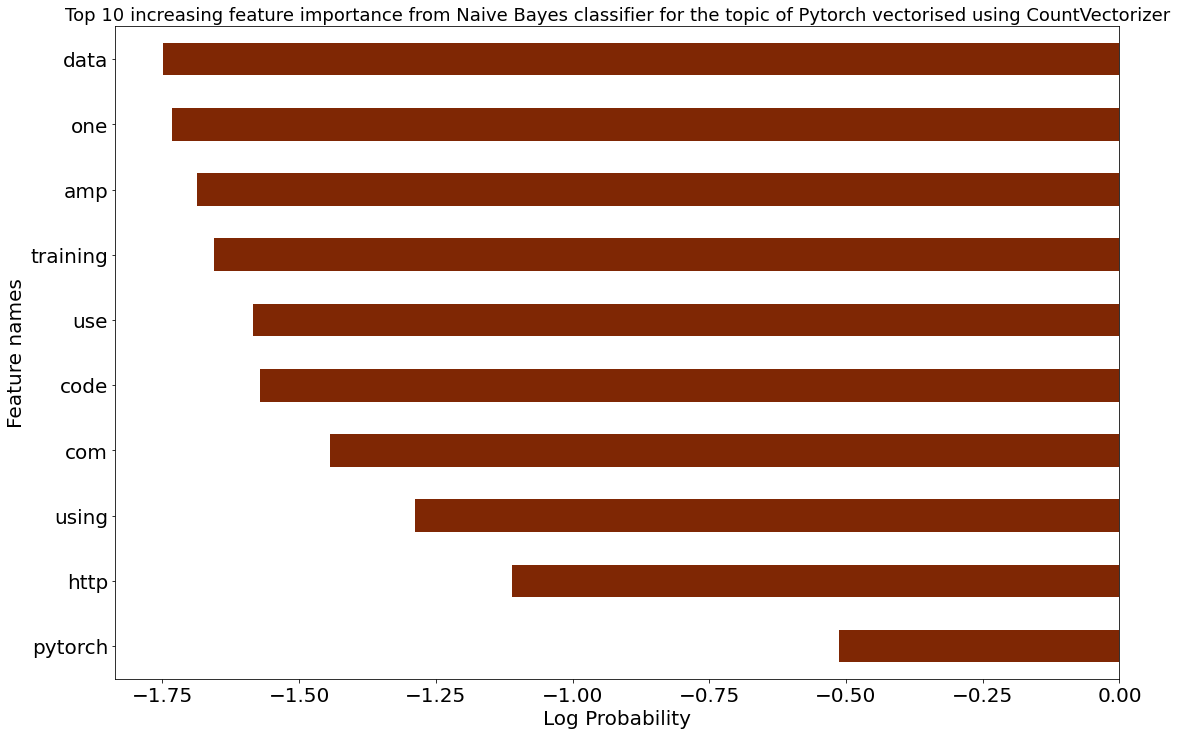

In [126]:
fig, ax1 = plt.subplots(figsize = (18,12))
pytorch_top_feature_df.plot(kind = "barh",
                            legend=False,
                            ax = ax1,
                            cmap = "Oranges_r"
                );

ax1.set_title("Top 10 increasing feature importance from Naive Bayes classifier for the topic of Pytorch vectorised using CountVectorizer", fontsize = 18);
ax1.set_ylabel("Feature names", fontsize = 20);
ax1.set_xlabel("Log Probability", fontsize = 20);
ax1.tick_params(axis='both', labelsize=20)

### Naive Bayes classifier with TF-IDF Vectorizer

**Find the best parameter with grid search**

In [21]:
nb_gs_idf = GridSearchCV(
    BernoulliNB(), 
    param_grid = {
        'alpha' : [0.001, 0.01, 0.1, 0.5, 1, 5, 10],
    },
    cv = 5)

nb_gs_idf.fit(X_train_idf, y_train)

#Get best param
nb_gs_idf.best_params_

{'alpha': 0.001}

**Fit the model with best parameter**

In [22]:
nb_idf = BernoulliNB(alpha = nb_gs_idf.best_params_["alpha"])
nb_idf.fit(X = X_train_idf,y = y_train)

# Save the model as pickel file
filename = 'models/NaiveBayes_IDF_model.pkl'
pickle.dump(nb_idf, open(filename, 'wb'))

nb_cv_score = cross_val_score(nb_idf, X_train_idf, y_train, cv = 10).mean()
nb_cv_score

0.8179547790339157

In [23]:
# Evaluate model on testing data.
nb_test_score = nb_idf.score(X_test_idf, y_test)
nb_test_score

0.7553648068669528

In [24]:
performance_dict["Naive Bayes TFIDF"] = [nb_cv_score,nb_test_score]

**Confusion matrix**

In [25]:
nb_predictions = nb_idf.predict(X_test_idf)
test_data_df["nb_idf"] = nb_predictions
tn, fp, fn, tp = confusion_matrix(y_test, nb_predictions).ravel()
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 209
False Positives: 27
False Negatives: 87
True Positives: 143


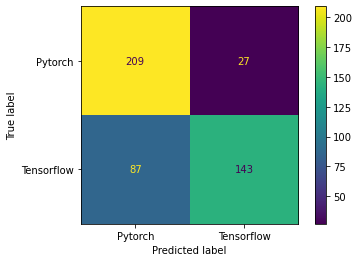

In [26]:
plot_confusion_matrix(nb_idf, X_test_idf, y_test, display_labels= cmatrix_display_labels);

**Naive Bayes Feature Importance**

In [27]:
#prob for Tensorflow class in descending order
tf_class_prob_sorted = nb_idf.feature_log_prob_[1, :].argsort()[::-1]
#prob for Pytorch class in descending order
pytorch_class_prob_sorted = nb_idf.feature_log_prob_[0, :].argsort()[::-1]

# Get a dictionary storing the top 10 feature importance and convert to dataframe
tf_top_feature_dict = {str(tvec.get_feature_names()[i]): nb_idf.feature_log_prob_[1, i] for i in tf_class_prob_sorted[:10]}
pytorch_top_feature_dict = {str(tvec.get_feature_names()[i]): nb_idf.feature_log_prob_[0, i] for i in pytorch_class_prob_sorted[:10]}

tf_top_feature_df = pd.DataFrame.from_dict(tf_top_feature_dict, orient = "index" , columns = ["log prob"])
pytorch_top_feature_df = pd.DataFrame.from_dict(pytorch_top_feature_dict, orient = "index" , columns = ["log prob"])

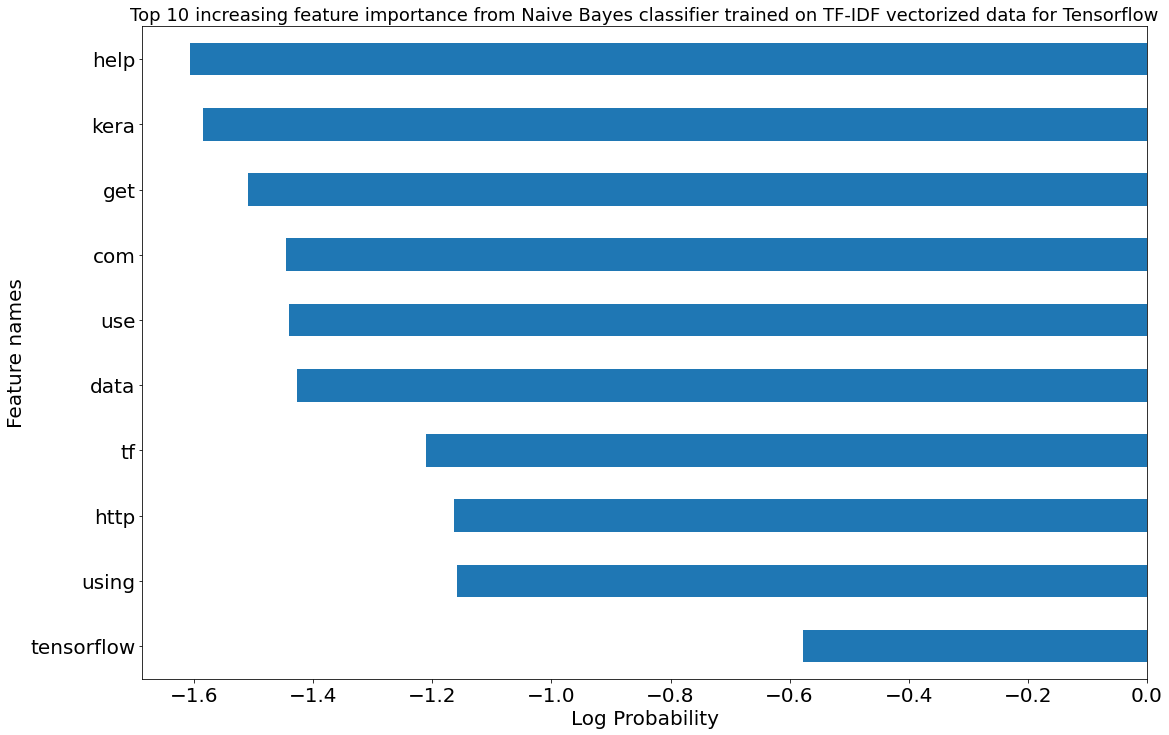

In [122]:
fig, ax = plt.subplots(figsize = (18,12))
tf_top_feature_df.plot(kind = "barh", 
                       legend = False,
                       ax = ax
                        );

ax.set_title("Top 10 increasing feature importance from Naive Bayes classifier trained on TF-IDF vectorized data for Tensorflow", fontsize = 18);
ax.set_ylabel("Feature names", fontsize = 20);
ax.set_xlabel("Log Probability", fontsize = 20);
ax.tick_params(axis='both', labelsize=20)

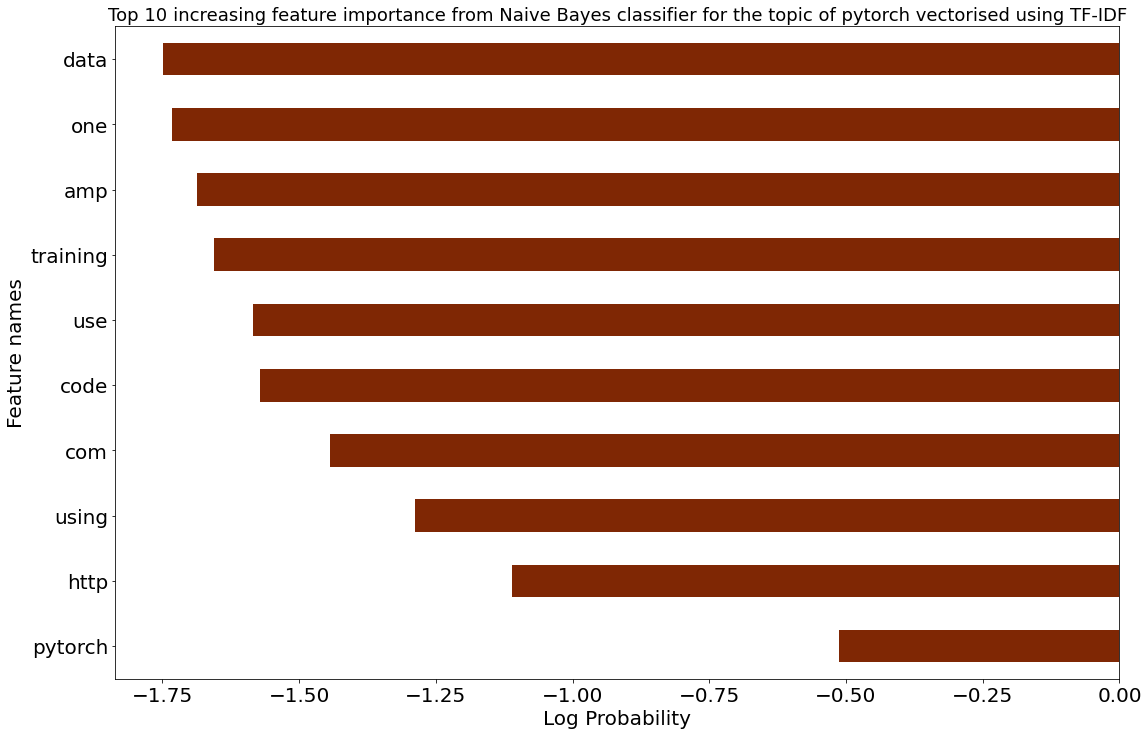

In [123]:
fig, ax1 = plt.subplots(figsize = (18,12))
pytorch_top_feature_df.plot(kind = "barh",
                            legend = False,
                            ax = ax1,
                            cmap = "Oranges_r"
                );

ax1.set_title("Top 10 increasing feature importance from Naive Bayes classifier for the topic of pytorch vectorised using TF-IDF", fontsize = 18);
ax1.set_ylabel("Feature names", fontsize = 20);
ax1.set_xlabel("Log Probability", fontsize = 20);
ax1.tick_params(axis='both', labelsize=20)

### Logistic Regression with Count Vectorizer

In [30]:
from sklearn.linear_model import LogisticRegression

**Find the best parameter with grid search**

In [31]:
lr_gs_cv = GridSearchCV(
    LogisticRegression(), 
    param_grid = {
        'C' : [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1],
        'random_state' : [42]
    },
    #n_jobs = -1,
    cv = 5)

lr_gs_cv.fit(X_train_cv, y_train)

#Get best param
lr_gs_cv.best_params_

{'C': 0.005, 'random_state': 42}

**Fit the model with best parameter**

In [32]:
# Instantiate logistic regression model
lr_cv = LogisticRegression(C = lr_gs_cv.best_params_["C"],
                           random_state = 42)

# Fit model to training data.
lr_cv.fit(X_train_cv, y_train)

# Save the model as pickle file
filename = 'models/LogRegress_CV_model.pkl'
pickle.dump(lr_cv, open(filename, 'wb'))

# Cross validate on training data.
lr_cv_score = cross_val_score(lr_cv, X_train_cv, y_train, cv = 10).mean()
lr_cv_score

0.8573638232271324

In [33]:
# Evaluate model on testing data.
lr_test_score = lr_cv.score(X_test_cv, y_test)
lr_test_score

0.8390557939914163

In [34]:
performance_dict["Log Regression CountVec"] = [lr_cv_score,lr_test_score]

**Confusion matrix**

In [35]:
lr_predictions = lr_cv.predict(X_test_cv)
test_data_df["lr_cv"] = lr_predictions
tn, fp, fn, tp = confusion_matrix(y_test, lr_predictions).ravel()
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 224
False Positives: 12
False Negatives: 63
True Positives: 167


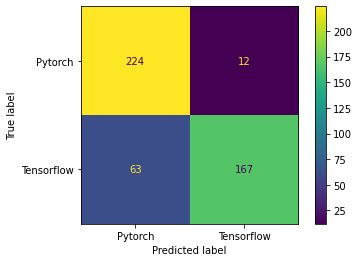

In [36]:
plot_confusion_matrix(lr_cv, X_test_cv, y_test, display_labels= cmatrix_display_labels);

**Logistic Regression Feature Importance**

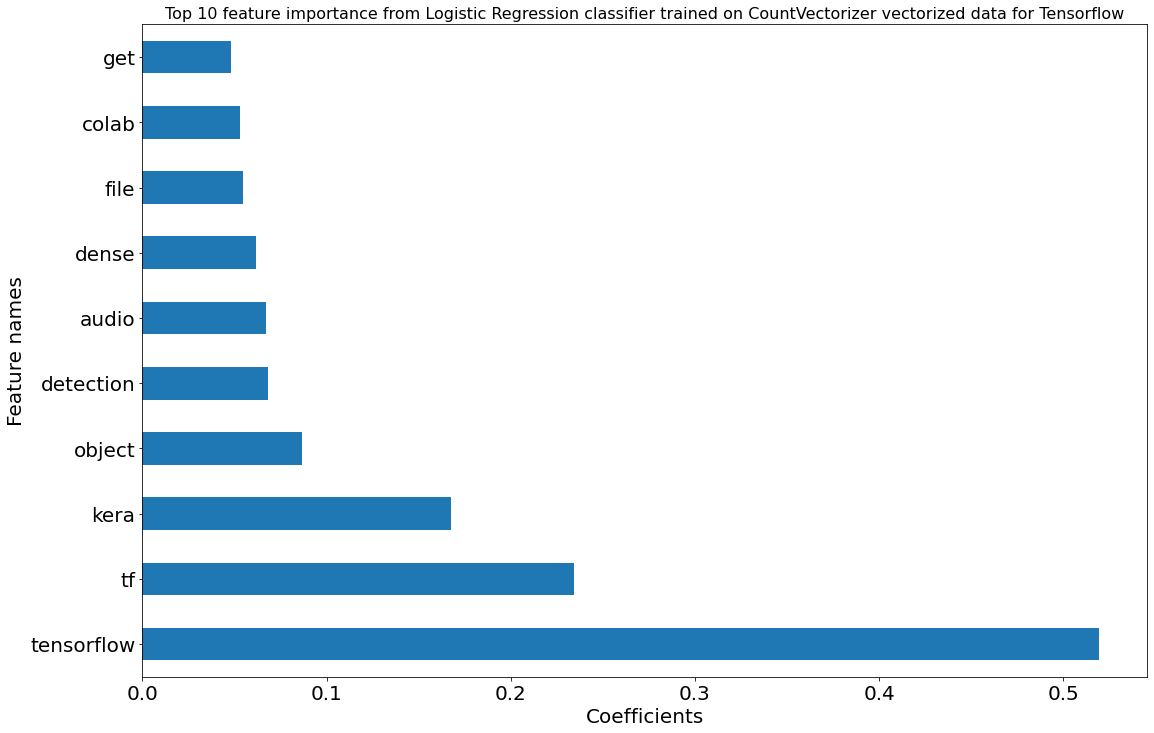

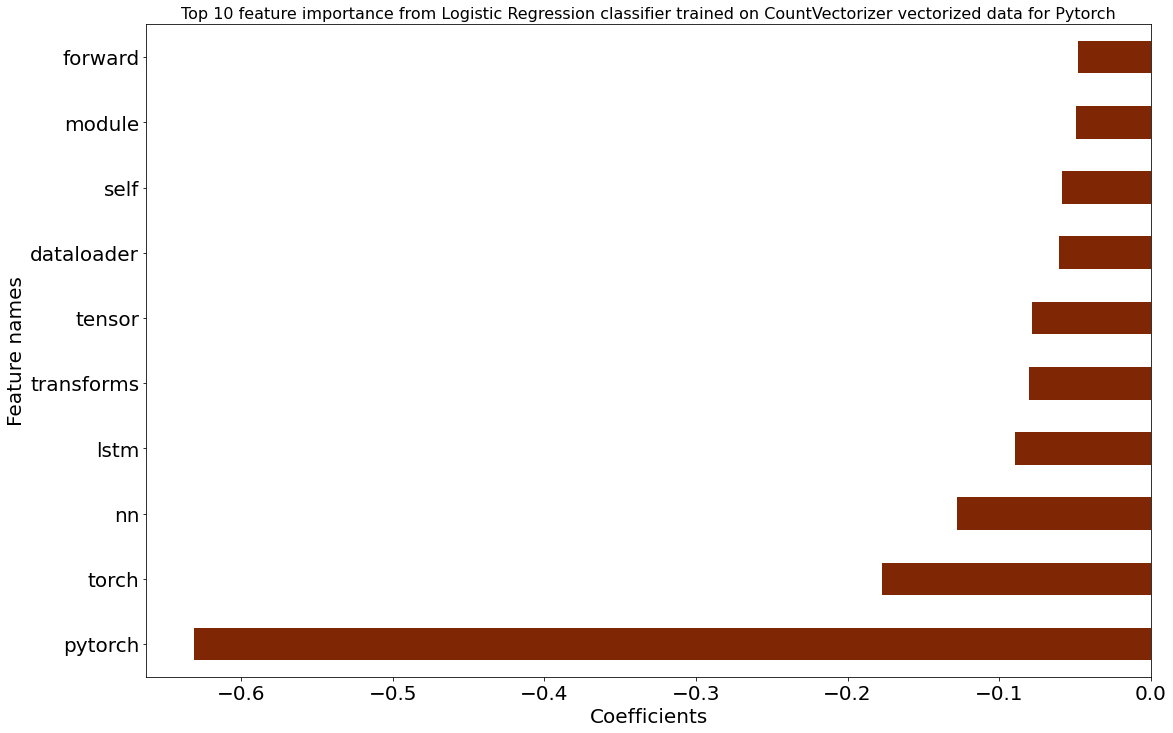

In [134]:
fig, ax = plt.subplots(figsize = (18,12))
# Coefficients for Pytorch class in descending order
lr_coefficients_sorted = lr_cv.coef_[0].argsort()[::-1]
#print(lr_idf.coef_[0][351])
#print(lr_idf.coef_[0][434])
# Get a dictionary storing the top 10 feature importance and convert to dataframe
lr_top_feature_dict = {str(tvec.get_feature_names()[i]): lr_cv.coef_[0][i] for i in lr_coefficients_sorted[:10]}
lr_btm_feature_dict = {str(tvec.get_feature_names()[j]): lr_cv.coef_[0][j] for j in lr_coefficients_sorted[-10:]}

lr_top_feature_df = pd.DataFrame.from_dict(lr_top_feature_dict, orient = "index" , columns = ["coefficients"])
lr_btm_feature_df = pd.DataFrame.from_dict(lr_btm_feature_dict, orient = "index" , columns = ["coefficients"]).sort_values(["coefficients"])

lr_top_feature_df.plot(kind = "barh", 
                       legend = False,
                       ax = ax
                );
ax.set_title("Top 10 increasing feature importance from Logistic Regression classifier trained on CountVectorizer vectorized data for Tensorflow", fontsize = 16);
ax.set_ylabel("Feature names", fontsize = 20);
ax.set_xlabel("Coefficients", fontsize = 20);
ax.tick_params(axis='both', labelsize=20)


fig, ax1 = plt.subplots(figsize = (18,12))
lr_btm_feature_df.plot(kind = "barh",
                       colormap = "Oranges_r",
                       legend = False,
                       ax = ax1
                    );

ax1.set_title("Top 10 increasing feature importance from Logistic Regression classifier trained on CountVectorizer vectorized data for Pytorch", fontsize = 16);
ax1.set_ylabel("Feature names", fontsize = 20);
ax1.set_xlabel("Coefficients", fontsize = 20);
ax1.tick_params(axis='both', labelsize=20)

### Logistic Regression with TF-IDF Vectorizer

**Find the best parameter with grid search**

In [38]:
lr_gs_idf = GridSearchCV(
    LogisticRegression(), 
    param_grid = {
        'C' : [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1],
        'random_state' : [42]
    },
    #n_jobs = -1,
    cv = 5)

lr_gs_idf.fit(X_train_idf, y_train)

#Get best param
lr_gs_idf.best_params_

{'C': 0.1, 'random_state': 42}

**Fit the model with best parameter**

In [39]:
# Instantiate logistic regression model
lr_idf = LogisticRegression(C = lr_gs_idf.best_params_["C"],
                            random_state = 42)

# Fit model to training data.
lr_idf.fit(X_train_idf, y_train)

# Save the model as pickle file
filename = 'models/LogRegress_IDF_model.pkl'
pickle.dump(lr_idf, open(filename, 'wb'))

# Cross validate on training data.
lr_cv_score = cross_val_score(lr_idf, X_train_idf, y_train, cv = 10).mean()
lr_cv_score

0.8559558067831448

In [40]:
# Evaluate model on testing data.
lr_test_score = lr_idf.score(X_test_idf, y_test)
lr_test_score

0.8540772532188842

In [41]:
performance_dict["Log Regression TFIDF"] = [lr_cv_score,lr_test_score]

**Confusion matrix**

In [42]:
lr_predictions = lr_idf.predict(X_test_idf)
test_data_df["lr_idf"] = lr_predictions
tn, fp, fn, tp = confusion_matrix(y_test, lr_predictions).ravel()
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 215
False Positives: 21
False Negatives: 47
True Positives: 183


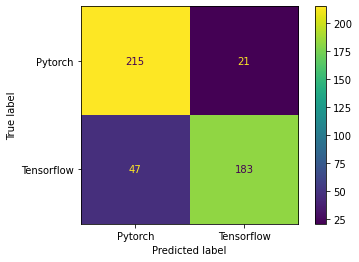

In [43]:
plot_confusion_matrix(lr_idf, X_test_idf, y_test, display_labels= cmatrix_display_labels);

**Logistic Regression Feature Importance**

In [44]:
lr_idf.coef_[0]

array([ 6.18753991e-02, -8.33065442e-03,  1.92789230e-02,  2.31339244e-02,
        1.76425696e-01,  3.76629807e-02,  7.48438977e-04,  1.71996798e-01,
        2.24022282e-02,  1.34981084e-02,  5.72975177e-02,  4.81390785e-03,
        8.93145381e-02,  2.14570803e-02,  4.26002398e-02, -2.47468457e-02,
        3.86430988e-02, -5.30476469e-03, -1.50886519e-02,  2.49118190e-01,
       -1.23144642e-02,  1.10608363e-01, -1.83127217e-02,  4.38221151e-03,
       -9.21627098e-02,  2.32691530e-02, -2.99728175e-02,  7.58723072e-02,
        9.23104536e-02, -3.79517371e-02,  2.53344204e-01, -1.25685531e-01,
        2.24538085e-03,  9.83988689e-03,  5.10423930e-02,  3.10906703e-03,
        8.67270445e-02, -7.01674129e-03, -1.65157684e-02, -3.62570826e-02,
        6.70121806e-02,  2.77702690e-02, -1.60118703e-02,  5.11895423e-02,
        5.33231364e-02,  8.88423431e-02,  1.90793255e-02, -4.25288404e-02,
       -8.01192959e-03,  8.86434235e-02, -5.20453400e-02,  1.45838105e-01,
        7.03478573e-02,  

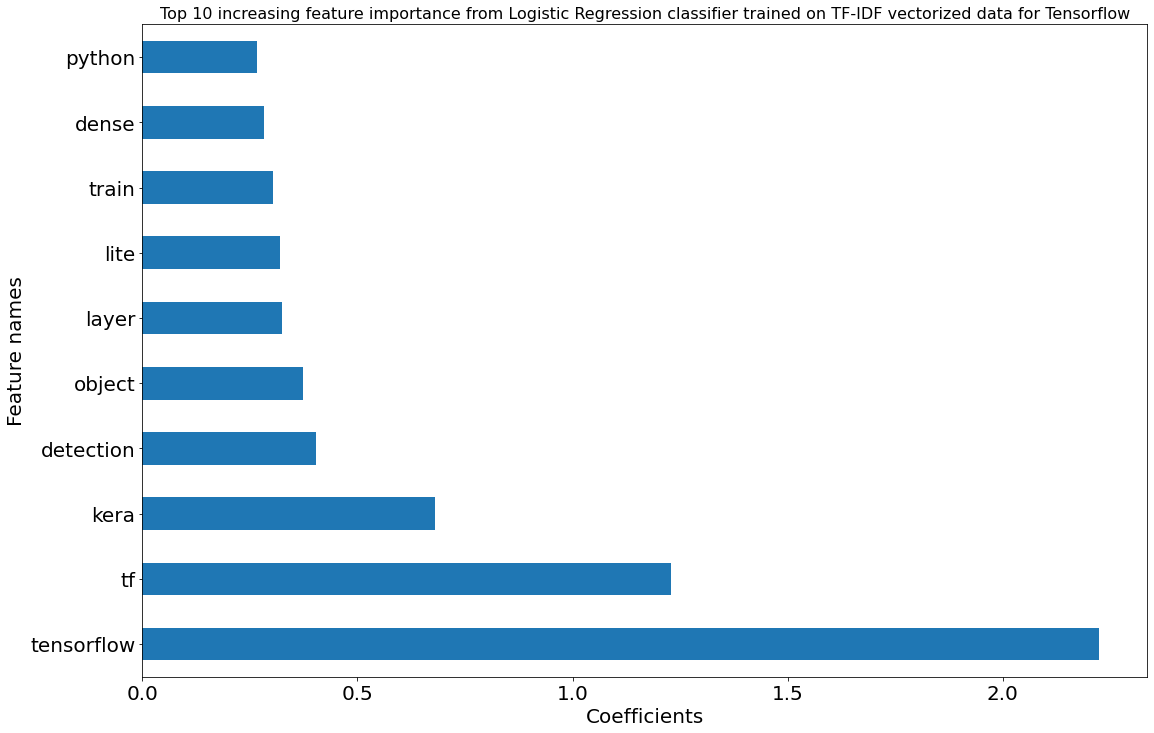

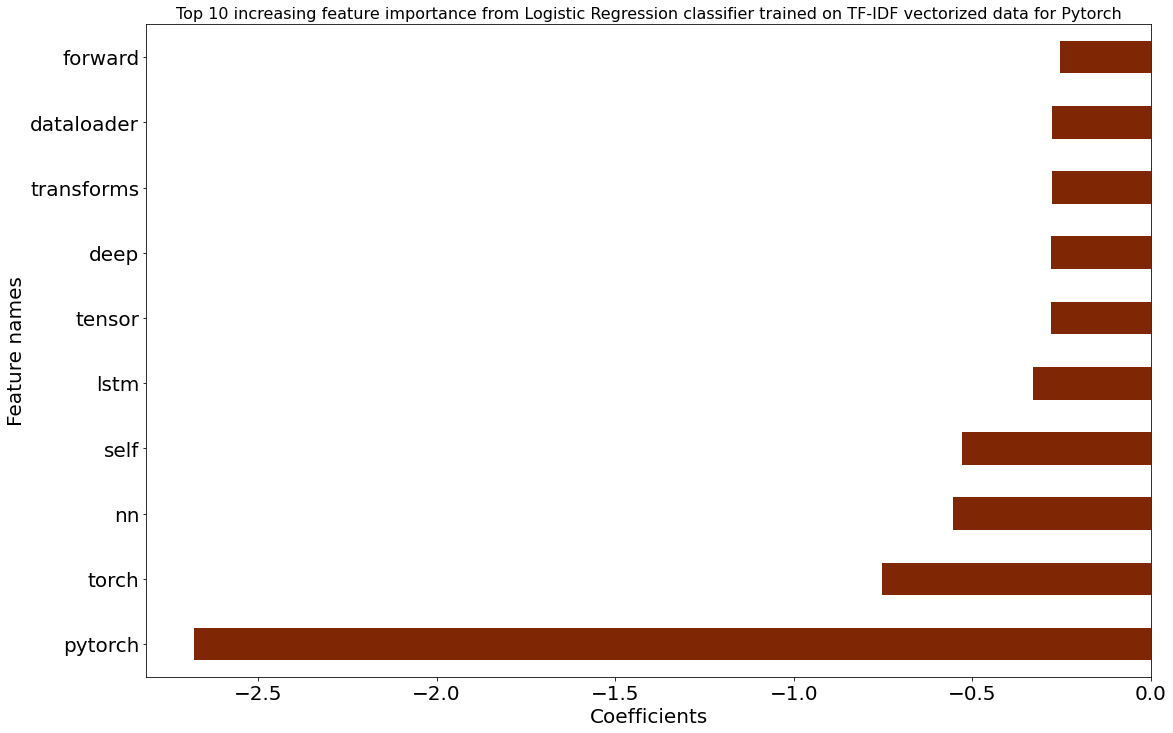

In [132]:
fig, ax = plt.subplots(figsize = (18,12))
# Coefficients for Pytorch class in descending order
lr_coefficients_sorted = lr_idf.coef_[0].argsort()[::-1]

# Get a dictionary storing the top 10 feature importance and convert to dataframe
lr_top_feature_dict = {str(tvec.get_feature_names()[i]): lr_idf.coef_[0][i] for i in lr_coefficients_sorted[:10]}
lr_btm_feature_dict = {str(tvec.get_feature_names()[j]): lr_idf.coef_[0][j] for j in lr_coefficients_sorted[-10:]}

lr_top_feature_df = pd.DataFrame.from_dict(lr_top_feature_dict, orient = "index" , columns = ["coefficients"])
lr_btm_feature_df = pd.DataFrame.from_dict(lr_btm_feature_dict, orient = "index" , columns = ["coefficients"]).sort_values(["coefficients"])

lr_top_feature_df.plot(kind = "barh", 
                       legend = False, 
                       ax = ax
                    );

ax.set_title("Top 10 increasing feature importance from Logistic Regression classifier trained on TF-IDF vectorized data for Tensorflow", fontsize = 16);
ax.set_ylabel("Feature names", fontsize = 20);
ax.set_xlabel("Coefficients", fontsize = 20);
ax.tick_params(axis='both', labelsize=20)

fig, ax1 = plt.subplots(figsize = (18,12))
lr_btm_feature_df.plot(kind = "barh",
                    colormap = "Oranges_r",
                    legend = False,
                    ax = ax1
                    );


ax1.set_title("Top 10 increasing feature importance from Logistic Regression classifier trained on TF-IDF vectorized data for Pytorch", fontsize = 16);
ax1.set_ylabel("Feature names", fontsize = 20);
ax1.set_xlabel("Coefficients", fontsize = 20);
ax1.tick_params(axis='both', labelsize=20)

In [46]:
#prob for Tensorflow class in descending order
tf_class_prob_sorted = nb_cv.feature_log_prob_[1, :].argsort()[::-1]
#prob for Pytorch class in descending order
pytorch_class_prob_sorted = nb_cv.feature_log_prob_[0, :].argsort()[::-1]

# Get a dictionary storing the top 10 feature importance and convert to dataframe
tf_top_feature_dict = {str(cvec.get_feature_names()[i]): nb_cv.feature_log_prob_[1, i] for i in tf_class_prob_sorted[:10]}
pytorch_top_feature_dict = {str(cvec.get_feature_names()[i]): nb_cv.feature_log_prob_[0, i] for i in pytorch_class_prob_sorted[:10]}

tf_top_feature_df = pd.DataFrame.from_dict(tf_top_feature_dict, orient = "index" , columns = ["log prob"])
pytorch_top_feature_df = pd.DataFrame.from_dict(pytorch_top_feature_dict, orient = "index" , columns = ["log prob"])

### Decision Trees with Count Vectorizer

In [47]:
# Import model.
from sklearn.tree import DecisionTreeClassifier

**Find the best parameter with grid search**

In [48]:
dt_gs_cv = GridSearchCV(
    DecisionTreeClassifier(), 
    param_grid = {
        'max_depth' : [2, 3, 5],
        'min_samples_split' : [5, 10, 15, 20],
        'min_samples_leaf' : [2, 4, 6],
        'ccp_alpha' : [0, 0.001, 0.01, 0.1, 1, 10],
        'random_state': [42]
    },
    cv = 5,
    #n_jobs = -1,
    verbose = True
)

dt_gs_cv.fit(X_train_cv, y_train)

#Get best param
dt_gs_cv.best_params_

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1080 out of 1080 | elapsed:    4.6s finished


{'ccp_alpha': 0,
 'max_depth': 5,
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'random_state': 42}

**Fit the model with best parameters**

In [49]:
dt_cv = DecisionTreeClassifier(ccp_alpha = dt_gs_cv.best_params_["ccp_alpha"],
                            max_depth = dt_gs_cv.best_params_["max_depth"],
                            min_samples_leaf = dt_gs_cv.best_params_["min_samples_leaf"],
                            min_samples_split = dt_gs_cv.best_params_["min_samples_split"], 
                            random_state = 42)

# Fit model.
dt_cv.fit(X_train_cv,y_train)

# Save the model as pickle file
filename = 'models/dt_CV_model.pkl'
pickle.dump(dt_cv, open(filename, 'wb'))


# Evaluate model on training data.
dt_cv_score = cross_val_score(dt_cv, X_train_cv, y_train, cv = 10).mean()
dt_cv_score

0.8473946557040083

In [50]:
# Evaluate model on testing data.
dt_test_score = dt_cv.score(X_test_cv,y_test)
dt_test_score

0.8175965665236051

In [51]:
performance_dict["Decision trees CountVec"] = [dt_cv_score,dt_test_score]

**Confusion matrix**

In [52]:
dt_predictions = dt_cv.predict(X_test_cv)
test_data_df["dt_cv"] = dt_predictions
tn, fp, fn, tp = confusion_matrix(y_test, dt_predictions).ravel()
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 235
False Positives: 1
False Negatives: 84
True Positives: 146


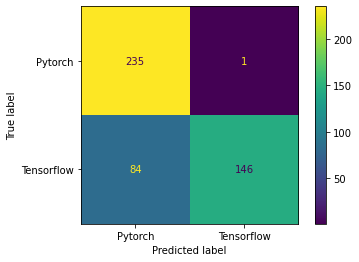

In [53]:
plot_confusion_matrix(dt_cv, X_test_cv, y_test, display_labels= cmatrix_display_labels);

**Look at the importance of features in Decision tree trained on training set**

Identify the top features that determines the classification of our text and posts to either Pytorch or Tensorflow subreddit. The length of feature_importances_ should match the columns of the training data set, which are the vectorized words.

In [54]:
importances = dt_cv.feature_importances_

# Get a list of indices of features sorted in decreasing importance value 
indices = np.argsort(importances)[::-1]

feature_list_importance = [cvec.get_feature_names()[indices[f]] for f in range(len(cvec.get_feature_names()))]

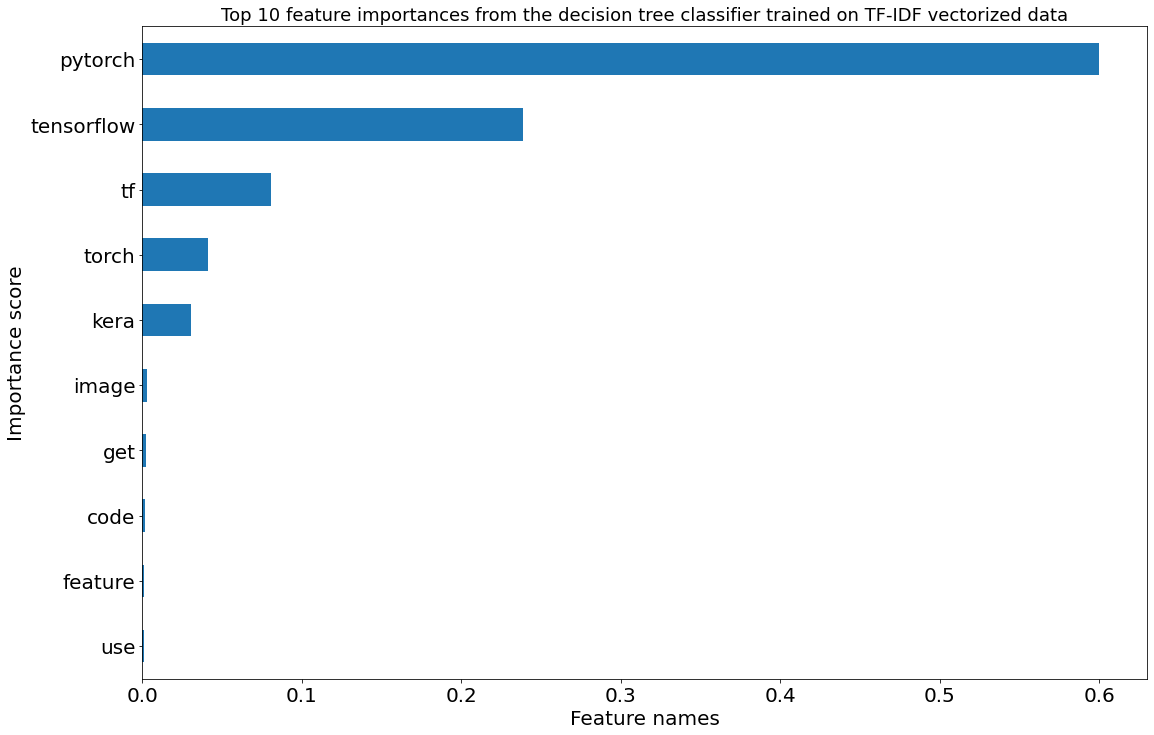

In [55]:
fig, ax = plt.subplots(figsize = (18,12))
top_feature_importance = {feature_list_importance[f]: importances[indices[f]] for f in range(10)}
# Convert dictionary to dataframe for plot
top_feature_df = pd.DataFrame.from_dict(top_feature_importance, orient = "index" , columns = ["Importance"])
top_feature_df = top_feature_df.sort_values("Importance", ascending = True)
top_feature_df.plot(kind = "barh",
                    legend = False,
                    ax = ax
                   );


ax.set_title("Top 10 feature importances from the decision tree classifier trained on TF-IDF vectorized data", fontsize = 18);
ax.set_xlabel("Feature names", fontsize = 20);
ax.set_ylabel("Importance score", fontsize = 20);
ax.tick_params(axis='both', labelsize=20)

### Decision Trees with TF-IDF Vectorizer

**Find the best parameter with grid search**

In [56]:
dt_gs_idf = GridSearchCV(
    DecisionTreeClassifier(), 
    param_grid = {
        'max_depth' : [2, 3, 5],
        'min_samples_split' : [5, 10, 15, 20],
        'min_samples_leaf' : [2, 4, 6],
        'ccp_alpha' : [0, 0.001, 0.01, 0.1, 1, 10],
        'random_state': [42]
    },
    cv = 5,
    #n_jobs = -1,
    verbose = True
)

dt_gs_idf.fit(X_train_idf, y_train)

# Save the model as pickle file
filename = 'models/dt_IDF_model.pkl'
pickle.dump(dt_gs_idf, open(filename, 'wb'))

#Get best param
dt_gs_idf.best_params_

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1080 out of 1080 | elapsed:    8.3s finished


{'ccp_alpha': 0,
 'max_depth': 5,
 'min_samples_leaf': 6,
 'min_samples_split': 5,
 'random_state': 42}

**Fit the model with best parameter**

In [57]:
# Evaluate model on testing data.
dt_idf = DecisionTreeClassifier(ccp_alpha = dt_gs_idf.best_params_["ccp_alpha"],
                            max_depth = dt_gs_idf.best_params_["max_depth"],
                            min_samples_leaf = dt_gs_idf.best_params_["min_samples_leaf"],
                            min_samples_split = dt_gs_idf.best_params_["min_samples_split"], 
                            random_state = 42)

# Fit model.
dt_idf.fit(X_train_cv,y_train)

# Save the model as pickle file
filename = 'models/dt_CV_model.pkl'
pickle.dump(dt_idf, open(filename, 'wb'))


# Evaluate model on training data.
dt_cv_score = cross_val_score(dt_idf, X_train_idf, y_train, cv = 10).mean()
dt_cv_score

0.848108941418294

In [58]:
# Evaluate model on testing data.
dt_test_score = dt_idf.score(X_test_idf,y_test)
dt_test_score

0.5386266094420601

In [59]:
performance_dict["Decision trees TFIDF"] = [dt_cv_score,dt_test_score]

**Confusion matrix**

In [60]:
dt_predictions = dt_idf.predict(X_test_idf)
test_data_df["dt_idf"] = dt_predictions
tn, fp, fn, tp = confusion_matrix(y_test, dt_predictions).ravel()
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 236
False Positives: 0
False Negatives: 215
True Positives: 15


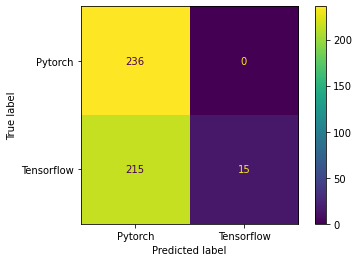

In [61]:
plot_confusion_matrix(dt_idf, X_test_idf, y_test, display_labels= cmatrix_display_labels);

**Look at the importance of features in Decision tree trained on training set**

Identify the top features that determines the classification of our text and posts to either Pytorch or Tensorflow subreddit. The length of feature_importances_ should match the columns of the training data set, which are the vectorized words.

In [62]:
importances = dt_idf.feature_importances_

# Get a list of indices of features sorted in decreasing importance value 
indices = np.argsort(importances)[::-1]

feature_list_importance = [tvec.get_feature_names()[indices[f]] for f in range(len(tvec.get_feature_names()))]

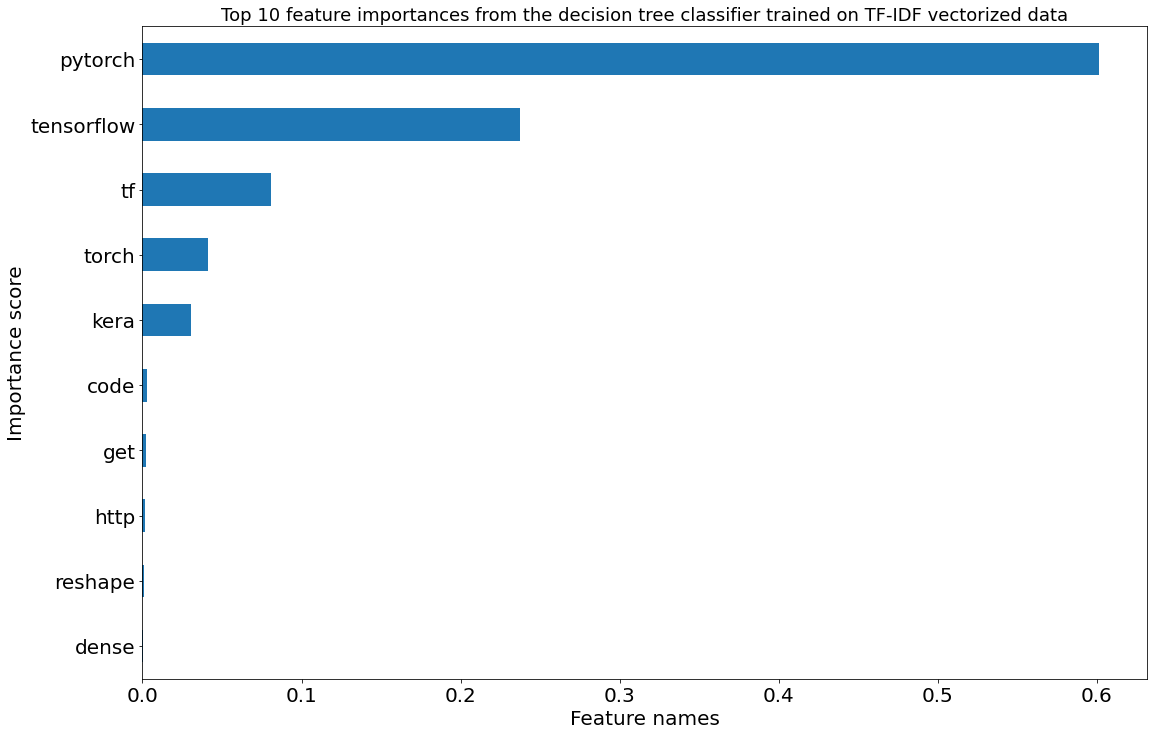

In [63]:
fig, ax = plt.subplots(figsize = (18,12))

top_feature_importance = {feature_list_importance[f]: importances[indices[f]] for f in range(10)}
# Convert dictionary to dataframe for plot
top_feature_df = pd.DataFrame.from_dict(top_feature_importance, orient = "index" , columns = ["Importance"])
top_feature_df = top_feature_df.sort_values("Importance", ascending = True)
top_feature_df.plot(kind = "barh",
                    legend = False,
                    ax = ax
                   );

ax.set_title("Top 10 feature importances from the decision tree classifier trained on TF-IDF vectorized data", fontsize = 18);
ax.set_xlabel("Feature names", fontsize = 20);
ax.set_ylabel("Importance score", fontsize = 20);
ax.tick_params(axis='both', labelsize=20)

### Random Forests with Count Vectorizer

In [64]:
# Import model.
from sklearn.ensemble import RandomForestClassifier

**Find the best parameter with grid search**

In [65]:
rfc_gs_cv = GridSearchCV(
    RandomForestClassifier(), 
    param_grid = {
        'n_estimators' : [100, 150, 200, 250],
        'max_depth': [None, 1, 2, 3, 4, 5, 6],
        'random_state' : [42]
    },
    cv = 5,
    #n_jobs = -1,
    verbose = True
)

rfc_gs_cv.fit(X_train_cv, y_train)

#Get best param
rfc_gs_cv.best_params_

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:   39.4s finished


{'max_depth': 5, 'n_estimators': 200, 'random_state': 42}

**Fit the model with best parameters**

In [66]:
rfc_cv = RandomForestClassifier(random_state = 42, 
                                max_depth = rfc_gs_cv.best_params_["max_depth"], 
                                n_estimators = rfc_gs_cv.best_params_["n_estimators"])

# Fit model.
rfc_cv.fit(X_train_cv,y_train)

# Save the model as pickle file
filename = 'models/rfc_CV_model.pkl'
pickle.dump(rfc_cv, open(filename, 'wb'))

# Evaluate model on training data.
rfc_cv_score = cross_val_score(rfc_cv, X_train_cv, y_train, cv = 10).mean()
rfc_cv_score

0.8703031860226105

In [67]:
# Evaluate model on testing data.
rfc_test_score = rfc_cv.score(X_test_cv,y_test)
rfc_test_score

0.8218884120171673

In [68]:
performance_dict["Random Forests CountVec"] = [rfc_cv_score,rfc_test_score]

**Confusion matrix**

In [69]:
rfc_predictions = rfc_cv.predict(X_test_cv)
test_data_df["rfc_cv"] = rfc_predictions
tn, fp, fn, tp = confusion_matrix(y_test, rfc_predictions).ravel()
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 227
False Positives: 9
False Negatives: 74
True Positives: 156


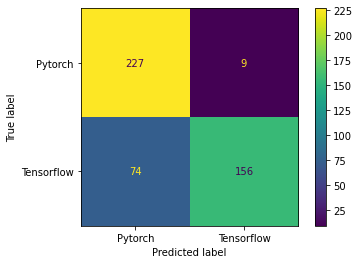

In [70]:
plot_confusion_matrix(rfc_cv, X_test_cv, y_test, display_labels= cmatrix_display_labels);

**Look at the importance of features in Random Forest trained on training set**

Identify the top features that determines the classification of our text and posts to either Pytorch or Tensorflow subreddit. The length of feature_importances_ should match the columns of the training data set, which are the vectorized words.

In [71]:
importances = rfc_cv.feature_importances_

# Get a list of indices of features sorted in decreasing importance value 
indices = np.argsort(importances)[::-1]

feature_list_importance = [cvec.get_feature_names()[indices[f]] for f in range(len(cvec.get_feature_names()))]

Retrieve the top 10 feature names, its importance value and the standard deviaton value across all trees

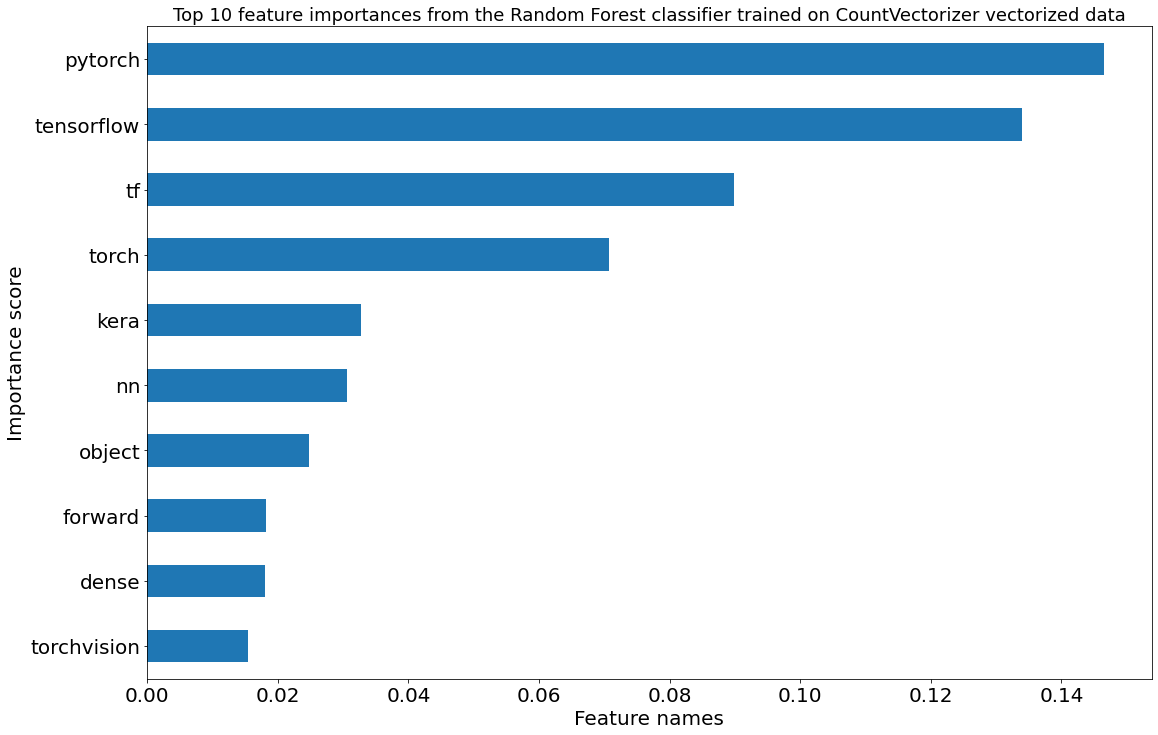

In [72]:
# Draw baseline accuracy
fig, ax = plt.subplots(figsize = (18,12))


top_feature_importance = {feature_list_importance[f]: importances[indices[f]] for f in range(10)}
# Convert dictionary to dataframe for plot
top_feature_df = pd.DataFrame.from_dict(top_feature_importance, orient = "index" , columns = ["Importance"])
top_feature_df = top_feature_df.sort_values("Importance", ascending = True)
top_feature_df.plot(kind = "barh",
                    legend = False,
                    ax = ax
                   );

ax.set_title("Top 10 feature importances from the Random Forest classifier trained on CountVectorizer vectorized data", fontsize = 18);
ax.set_xlabel("Feature names", fontsize = 20);
ax.set_ylabel("Importance score", fontsize = 20);
ax.tick_params(axis='both', labelsize=20)

### Random Forests with TF-IDF Vectorizer

**Find the best parameter with grid search**

In [73]:
rfc_gs_idf = GridSearchCV(
    RandomForestClassifier(), 
    param_grid = {
        'n_estimators' : [100, 150, 200, 250],
        'max_depth': [None, 1, 2, 3, 4, 5, 6],
        'random_state' : [42]
    },
    cv = 5,
    #n_jobs = -1,
    verbose = True
)

rfc_gs_idf.fit(X_train_idf, y_train)

#Get best param
rfc_gs_idf.best_params_

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:   42.1s finished


{'max_depth': 5, 'n_estimators': 100, 'random_state': 42}

**Fit the model with best parameter**

In [74]:
rfc_idf = RandomForestClassifier(random_state = 42,
                                 max_depth = rfc_gs_idf.best_params_["max_depth"],
                                 n_estimators = rfc_gs_idf.best_params_["n_estimators"])

# Fit model.
rfc_idf.fit(X_train_idf,y_train)

# Save the model as pickle file
filename = 'models/rfc_IDF_model.pkl'
pickle.dump(rfc_idf, open(filename, 'wb'))

# Evaluate model on training data.
rfc_cv_score = cross_val_score(rfc_idf, X_train_idf, y_train, cv = 10).mean()
rfc_cv_score

0.8609866392600207

In [75]:
# Evaluate model on testing data.
rfc_test_score = rfc_idf.score(X_test_idf,y_test)
rfc_test_score

0.8261802575107297

In [76]:
performance_dict["Random Forests TFIDF"] = [rfc_cv_score,rfc_test_score]

**Confusion matrix**

In [77]:
rfc_predictions = rfc_idf.predict(X_test_idf)
test_data_df["rfc_idf"] = rfc_predictions
tn, fp, fn, tp = confusion_matrix(y_test, rfc_predictions).ravel()
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 223
False Positives: 13
False Negatives: 68
True Positives: 162


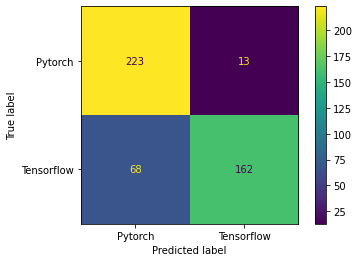

In [78]:
plot_confusion_matrix(rfc_idf, X_test_idf, y_test, display_labels= cmatrix_display_labels);

**Look at the importance of features in Random Forest trained on training set**

Identify the top features that determines the classification of our text and posts to either Pytorch or Tensorflow subreddit. The length of feature_importances_ should match the columns of the training data set, which are the vectorized words.

In [79]:
importances = rfc_idf.feature_importances_

# Get a list of indices of features sorted in decreasing importance value 
indices = np.argsort(importances)[::-1]

feature_list_importance = [tvec.get_feature_names()[indices[f]] for f in range(len(tvec.get_feature_names()))]

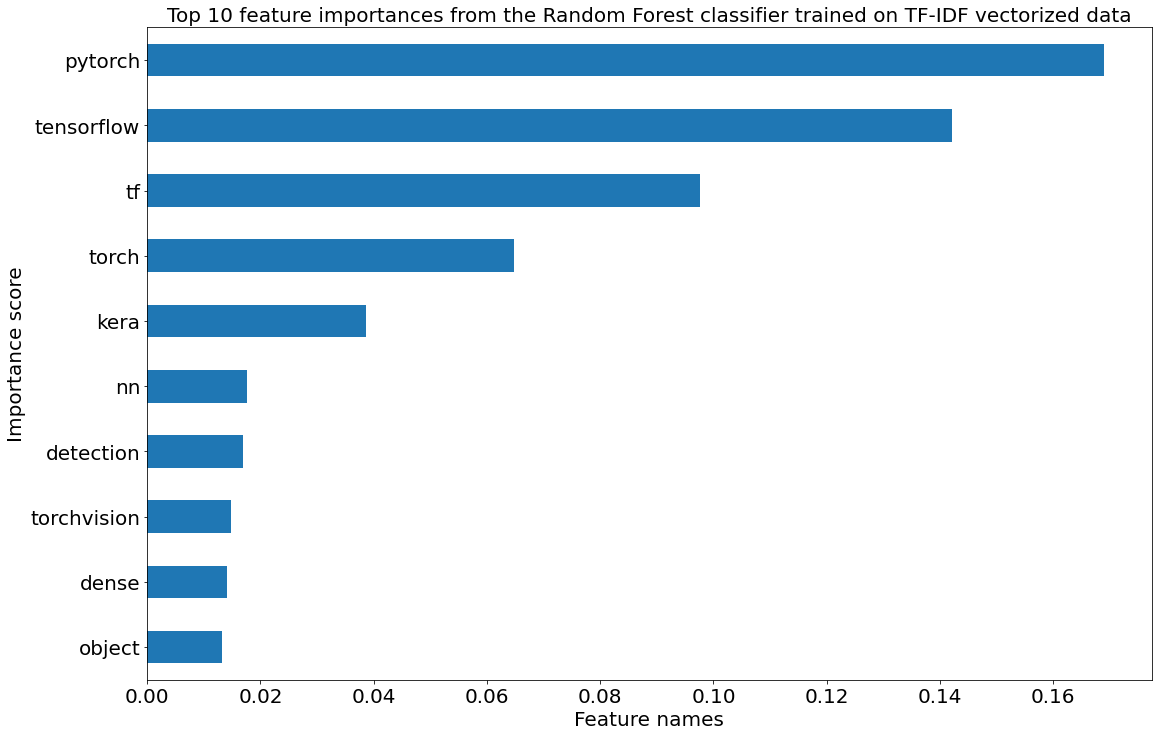

In [80]:
# Draw baseline accuracy
fig, ax = plt.subplots(figsize = (18,12))

top_feature_importance = {feature_list_importance[f]: importances[indices[f]] for f in range(10)}
# Convert dictionary to dataframe for plot
top_feature_df = pd.DataFrame.from_dict(top_feature_importance, orient = "index" , columns = ["Importance"])
top_feature_df = top_feature_df.sort_values("Importance", ascending = True)
top_feature_df.plot(kind = "barh",
                    legend = False,
                   ax = ax);


ax.set_title("Top 10 feature importances from the Random Forest classifier trained on TF-IDF vectorized data", fontsize = 20);
ax.set_xlabel("Feature names", fontsize = 20);
ax.set_ylabel("Importance score", fontsize = 20);
ax.tick_params(axis='both', labelsize=20)

### ExtraTrees with Count Vectorizer

In [81]:
# Import model.
from sklearn.ensemble import ExtraTreesClassifier

**Find the best parameter with grid search**

In [82]:
etc_gs_cv = GridSearchCV(
    ExtraTreesClassifier(), 
    param_grid = {
        'n_estimators' : [100, 150, 200, 250, 300],
        'max_depth': [None, 1, 2, 3, 4, 5, 6],
        'random_state': [42]
    },
    cv = 5,
    #n_jobs = -1,
    verbose = True
)

etc_gs_cv.fit(X_train_cv, y_train)

#Get best param
etc_gs_cv.best_params_

Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 175 out of 175 | elapsed:   43.2s finished


{'max_depth': None, 'n_estimators': 250, 'random_state': 42}

**Fit the model with best parameters**

In [83]:
etc_cv = ExtraTreesClassifier(random_state = 42, max_depth = etc_gs_cv.best_params_["max_depth"], n_estimators = etc_gs_cv.best_params_["n_estimators"])

# Fit model.
etc_cv.fit(X_train_cv,y_train)

# Save the model as pickle file
filename = 'models/etc_CV_model.pkl'
pickle.dump(etc_cv, open(filename, 'wb'))

# Evaluate model on training data.
etc_cv_score = cross_val_score(etc_cv, X_train_cv, y_train, cv = 10).mean()
etc_cv_score

0.8466187050359713

In [84]:
# Evaluate model on testing data.
etc_test_score = etc_cv.score(X_test_cv,y_test)
etc_test_score

0.8562231759656652

In [85]:
performance_dict["Extra Trees CountVec"] = [etc_cv_score, etc_test_score]

**Confusion matrix**

In [86]:
etc_predictions = etc_cv.predict(X_test_cv)
test_data_df["etc_cv"] = etc_predictions
tn, fp, fn, tp = confusion_matrix(y_test, etc_predictions).ravel()
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 203
False Positives: 33
False Negatives: 34
True Positives: 196


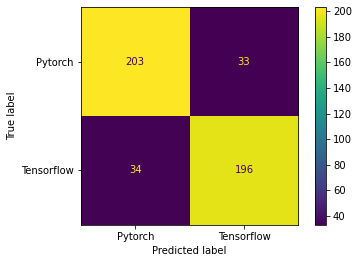

In [87]:
plot_confusion_matrix(etc_cv, X_test_cv, y_test, display_labels= cmatrix_display_labels);

**Look at the importance of features in Extra Tree trained on training set**

Identify the top features that determines the classification of our text and posts to either Pytorch or Tensorflow subreddit.

In [88]:
importances = etc_cv.feature_importances_

# Get a list of indices of features sorted in decreasing importance value 
indices = np.argsort(importances)[::-1]

feature_list_importance = [cvec.get_feature_names()[indices[f]] for f in range(len(cvec.get_feature_names()))]

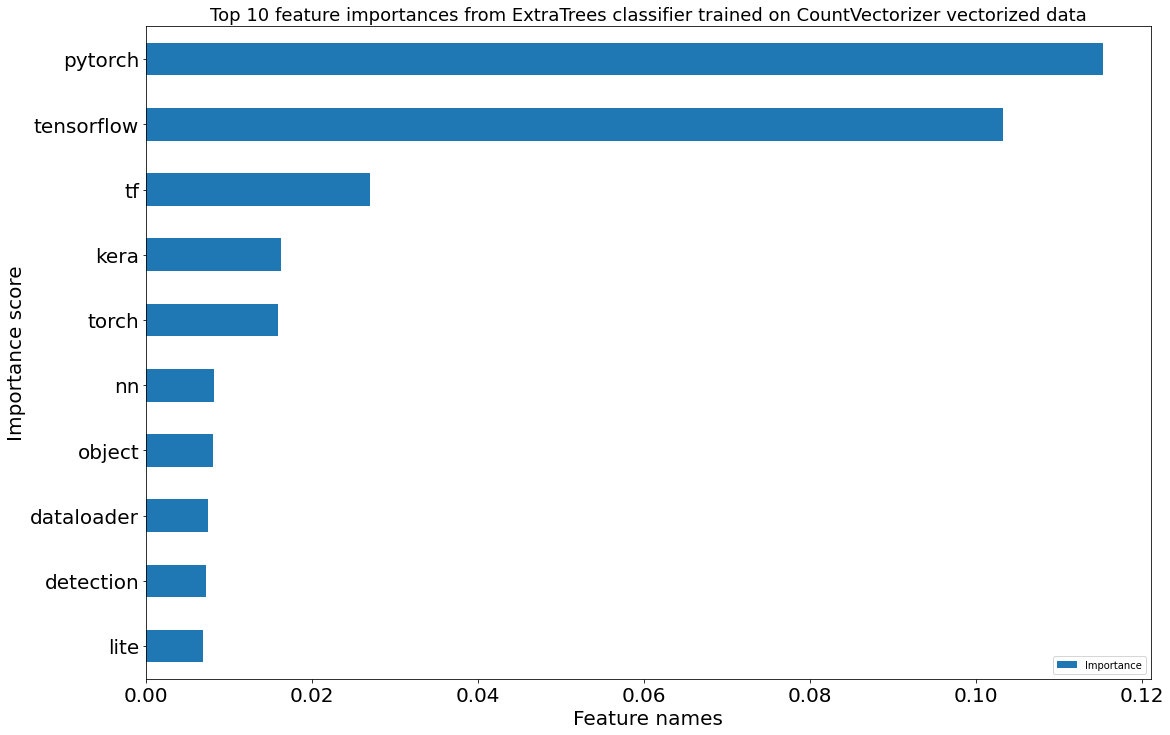

In [89]:
fig, ax = plt.subplots(figsize = (18,12))

top_feature_importance = {feature_list_importance[f]: importances[indices[f]] for f in range(10)}
# Convert dictionary to dataframe for plot
top_feature_df = pd.DataFrame.from_dict(top_feature_importance, orient = "index" , columns = ["Importance"])
top_feature_df = top_feature_df.sort_values("Importance", ascending = True)
top_feature_df.plot(kind = "barh",
                    label = False,
                    ax = ax
                   );

ax.set_title("Top 10 feature importances from ExtraTrees classifier trained on CountVectorizer vectorized data", fontsize = 18);
ax.set_xlabel("Feature names", fontsize = 20);
ax.set_ylabel("Importance score", fontsize = 20);
ax.tick_params(axis='both', labelsize=20)

### ExtraTrees with TF-IDF Vectorizer

**Find the best parameter with grid search**

In [90]:
etc_gs_idf = GridSearchCV(
    ExtraTreesClassifier(), 
    param_grid = {
        'n_estimators' : [100, 150, 200, 250, 300],
        'max_depth': [None, 1, 2, 3, 4, 5, 6],
        'random_state': [42]
    },
    cv = 5,
    #n_jobs = -1,
    verbose = True
)

etc_gs_idf.fit(X_train_idf, y_train)

#Get best param
etc_gs_idf.best_params_

Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 175 out of 175 | elapsed:   46.2s finished


{'max_depth': None, 'n_estimators': 300, 'random_state': 42}

**Fit the model with best parameter**

In [91]:
etc_idf = ExtraTreesClassifier(random_state = 42, max_depth = etc_gs_idf.best_params_["max_depth"], n_estimators = etc_gs_idf.best_params_["n_estimators"])

# Fit model.
etc_idf.fit(X_train_idf, y_train)

# Save the model as pickle file
filename = 'models/etc_IDF_model.pkl'
pickle.dump(etc_idf, open(filename, 'wb'))

# Evaluate model on training data.
etc_cv_score = cross_val_score(etc_idf, X_train_idf, y_train, cv = 10).mean()
etc_cv_score

0.853792394655704

In [92]:
# Evaluate model on testing data.
etc_test_score = etc_idf.score(X_test_idf,y_test)
etc_test_score

0.8433476394849786

In [93]:
performance_dict["Extra Trees TFIDF"] = [etc_cv_score, etc_test_score]

**Confusion matrix**

In [94]:
etc_predictions = etc_idf.predict(X_test_idf)
test_data_df["etc_idf"] = etc_predictions
tn, fp, fn, tp = confusion_matrix(y_test, etc_predictions).ravel()
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 202
False Positives: 34
False Negatives: 39
True Positives: 191


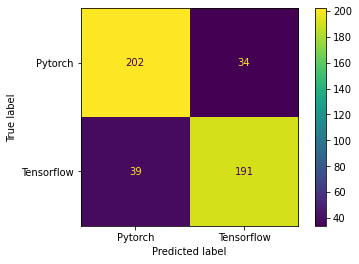

In [95]:
plot_confusion_matrix(etc_idf, X_test_idf, y_test, display_labels= cmatrix_display_labels);

**Look at the importance of features in Extra Tree trained on training set**

Identify the top features that determines the classification of our text and posts to either Pytorch or Tensorflow subreddit.

In [96]:
importances = etc_idf.feature_importances_

# Get a list of indices of features sorted in decreasing importance value 
indices = np.argsort(importances)[::-1]

feature_list_importance = [tvec.get_feature_names()[indices[f]] for f in range(len(tvec.get_feature_names()))]

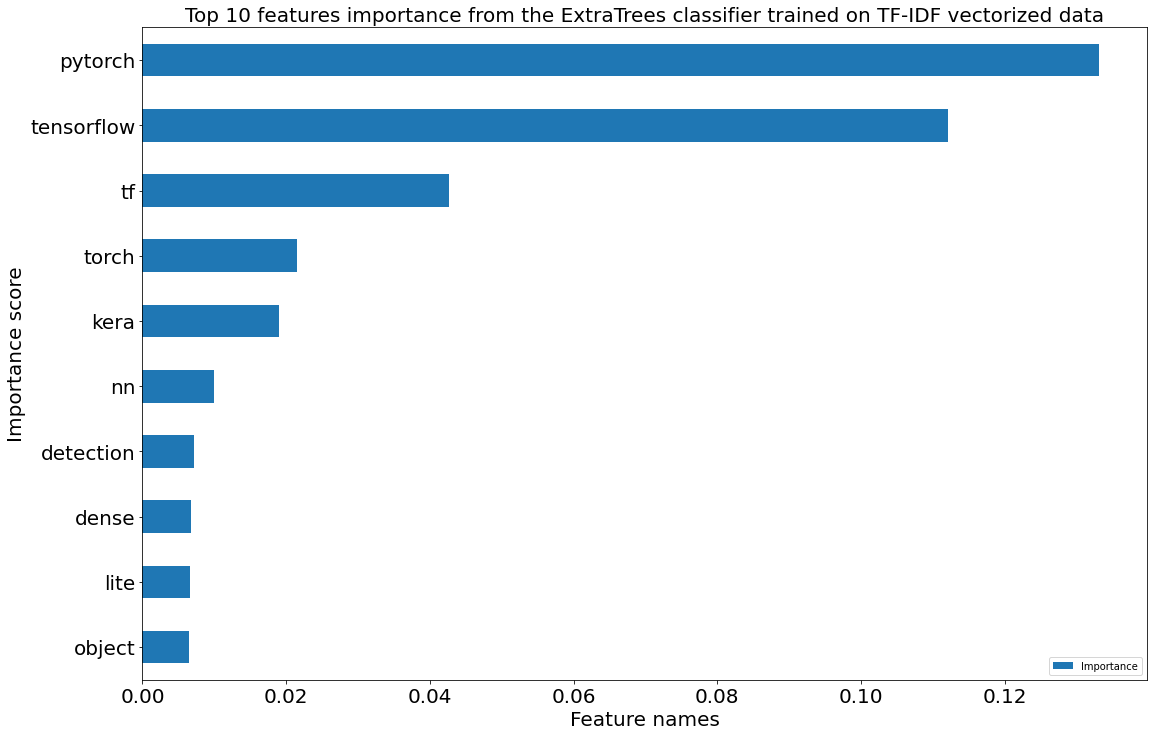

In [97]:
fig, ax1 = plt.subplots(figsize = (18,12))
top_feature_importance = {feature_list_importance[f]: importances[indices[f]] for f in range(10)}
# Convert dictionary to dataframe for plot
top_feature_df = pd.DataFrame.from_dict(top_feature_importance, orient = "index" , columns = ["Importance"])
top_feature_df = top_feature_df.sort_values("Importance", ascending = True)
top_feature_df.plot(kind = "barh",
                    label = False,
                    ax = ax1
                   );

ax1.set_title("Top 10 features importance from the ExtraTrees classifier trained on TF-IDF vectorized data", fontsize = 20);
ax1.set_xlabel("Feature names", fontsize = 20);
ax1.set_ylabel("Importance score", fontsize = 20);
ax1.tick_params(axis='both', labelsize=20)

## Summary of models
From the models considered above, we see that regardless of the vectorization techniques used (limited to 500 words), there is not much difference in the performance of the classifiers on train and test sets as it is approximately 1% to 2%. The only exception is for the Decision tree classifier where there is more than 10% difference in the accuracy for the test set. 

Looking at the data below, the Naive Bayes model seems to be overfitted for my case as compared to the other models. In terms of performance and efficiency, logistic regression is the best performing classifier since the average accuracy on training data and test data are relatively close and attains one of the best accuracy in both aspects, suggesting that the model is not underfitted or overfitted.

Answering the problem statement, the logistic regression model would be a **better classifier** compared to Naive Bayes classifier.

In [98]:
performance_dict

{'Naive Bayes CountVec': [0.8179547790339157, 0.7553648068669528],
 'Naive Bayes TFIDF': [0.8179547790339157, 0.7553648068669528],
 'Log Regression CountVec': [0.8573638232271324, 0.8390557939914163],
 'Log Regression TFIDF': [0.8559558067831448, 0.8540772532188842],
 'Decision trees CountVec': [0.8473946557040083, 0.8175965665236051],
 'Decision trees TFIDF': [0.848108941418294, 0.5386266094420601],
 'Random Forests CountVec': [0.8703031860226105, 0.8218884120171673],
 'Random Forests TFIDF': [0.8609866392600207, 0.8261802575107297],
 'Extra Trees CountVec': [0.8466187050359713, 0.8562231759656652],
 'Extra Trees TFIDF': [0.853792394655704, 0.8433476394849786]}

In [99]:
performance_dict_df = df.from_dict(performance_dict, 
                                orient='index', 
                                columns = ["Average accuracy for train data","Accuracy for test data"]
                               )
performance_dict_df.index.name = "Models on different vectorized data"
performance_dict_df.reset_index(inplace = True)
performance_dict_df["diff"] = performance_dict_df["Average accuracy for train data"] - performance_dict_df["Accuracy for test data"]

# Split the dataframe according to the vectorization technique

performance_dict_df_cv = performance_dict_df.iloc[np.arange(0,10,2),:]
performance_dict_df_cv.set_index("Models on different vectorized data", inplace = True)
performance_dict_df_idf = performance_dict_df.iloc[np.arange(1,11,2),:]
performance_dict_df_idf.set_index("Models on different vectorized data", inplace = True)

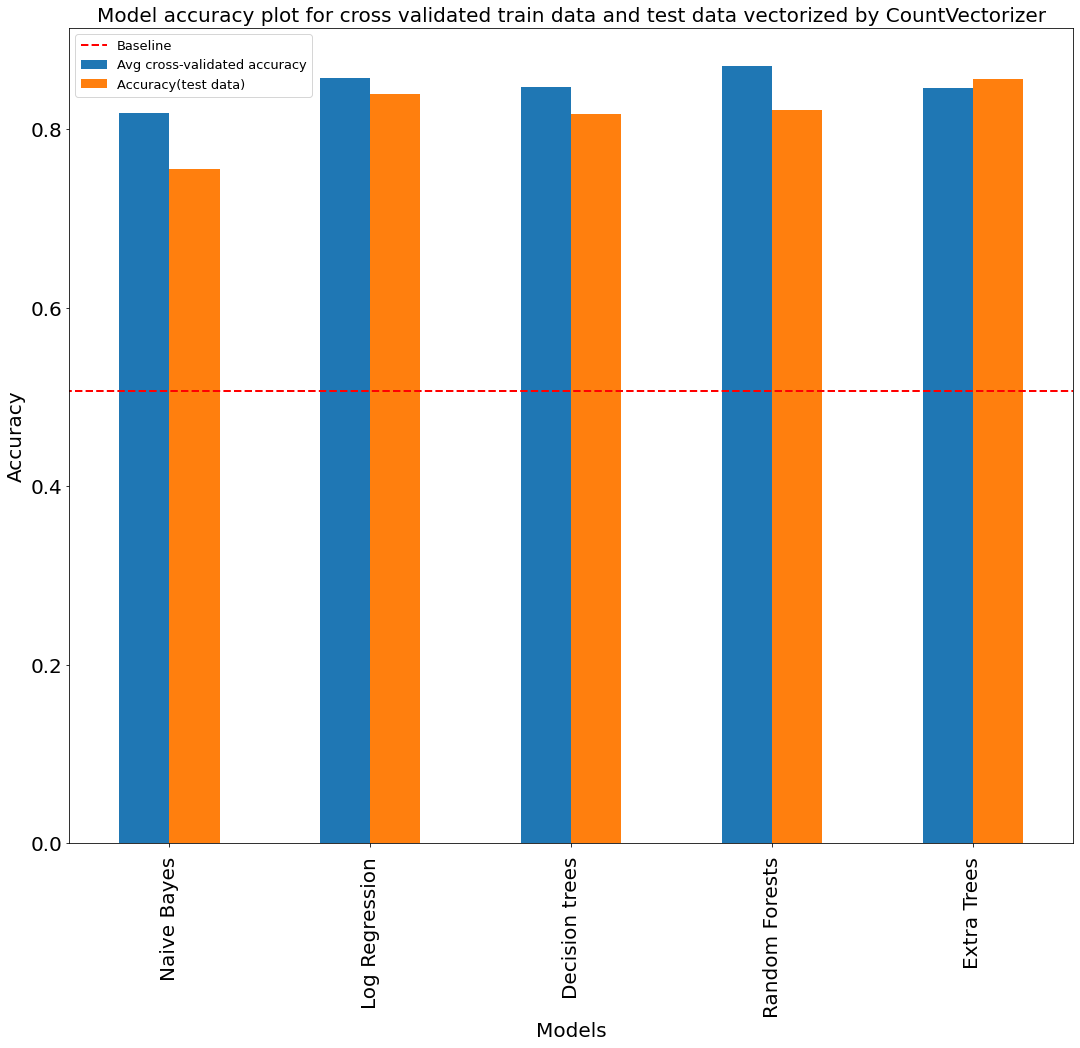

In [100]:
fig, ax0 = plt.subplots(figsize=(18,15))
performance_dict_df_cv[["Average accuracy for train data","Accuracy for test data"]].plot(kind = "bar",
                                                                                          ax = ax0)
baseline = y.value_counts(normalize = True).max()


# Draw baseline accuracy
ax0.hlines(baseline, xmin=-1, xmax=18, color='r', linestyle='--', lw=2);

# Relabel the model name for plots
substr_cv = performance_dict_df_cv.index.str.replace("CountVec", "")

# Label the plots
ax0.set_title("Model accuracy plot for cross validated train data and test data vectorized by CountVectorizer", fontsize = 20);
ax0.set_xlabel("Models", fontsize = 20)
ax0.set_xticklabels(substr_cv, fontsize = 20)
ax0.tick_params(axis='both', labelsize=20)
ax0.set_ylabel("Accuracy", fontsize = 20)
ax0.legend(["Baseline","Avg cross-validated accuracy","Accuracy(test data)"], fontsize = 13);


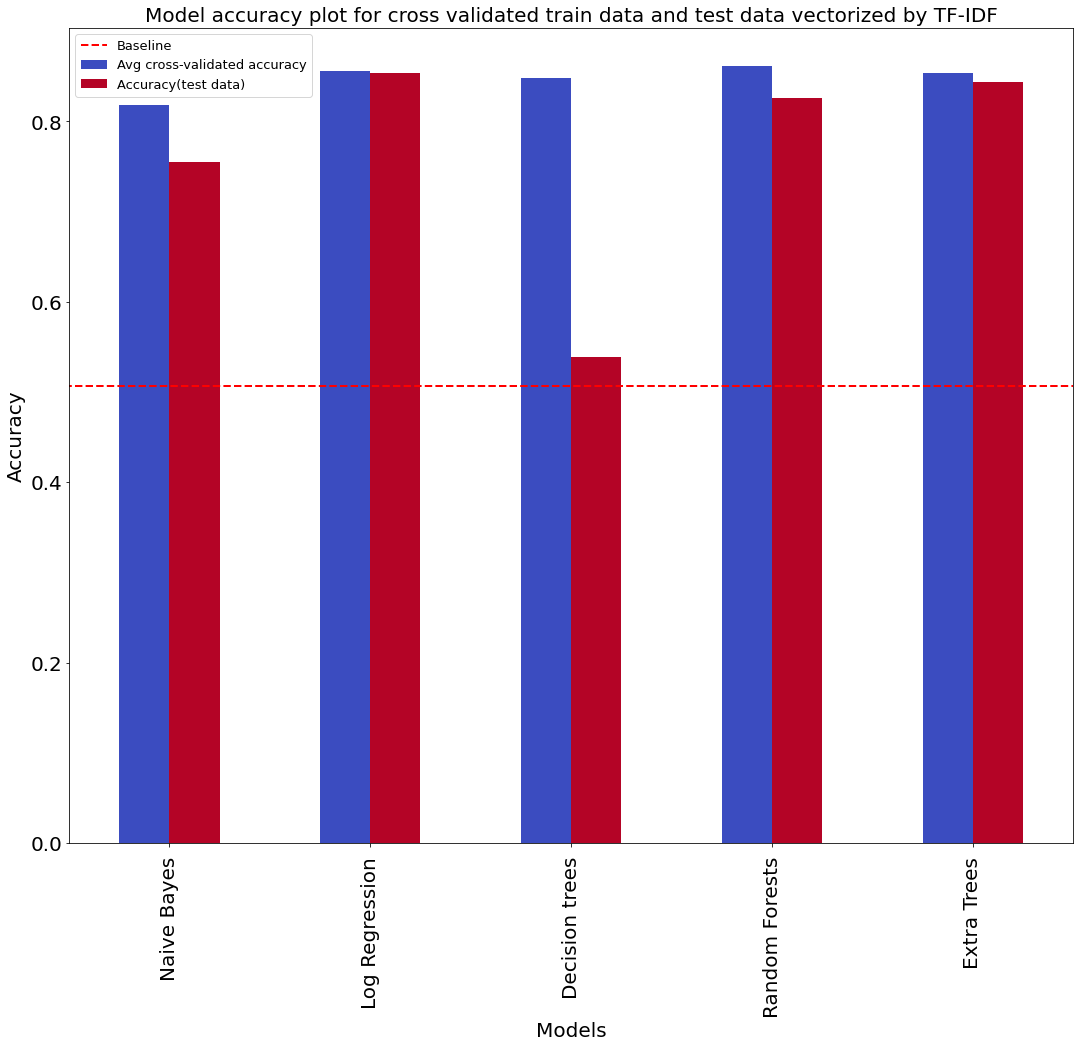

In [101]:
fig, ax1 = plt.subplots(figsize=(18,15))

performance_dict_df_idf[["Average accuracy for train data","Accuracy for test data"]].plot(kind = "bar",
                                                                                           ax = ax1, colormap = "coolwarm");
baseline = y.value_counts(normalize = True).max()


# Draw baseline accuracy
ax1.hlines(baseline, xmin=-1, xmax=18, color='r', linestyle='--', lw=2);

# Relabel the model name for plots
substr_idf = performance_dict_df_idf.index.str.replace("TFIDF", "")

ax1.set_title("Model accuracy plot for cross validated train data and test data vectorized by TF-IDF", fontsize = 20);
ax1.set_xlabel("Models", fontsize = 20);
ax1.set_ylabel("Accuracy", fontsize = 20);
ax1.tick_params(axis='both', labelsize=20)
ax1.set_xticklabels(substr_idf)
ax1.legend(["Baseline","Avg cross-validated accuracy","Accuracy(test data)"], fontsize = 13);


## Analysing misclassified data
Consider further analysis on Naive Bayes classifer and logistic regression classifer model. From the *selftext* and *title* columns, we can see that there are posts do not have any wordings containing either tensorflow or pytorch, which resulted in possible misclassification by the model. It is also noted the use of shortforms such as **"tf"**, which is one of the top few features explained by the models did not necessary guarantee the correct classification of posts by the models, possibly due to the influence of other words.

In [102]:
def test_data_wrongly_classified(df, test_data_df, model_col_name):
    """
    A function that returns the data entries where a classification made by a classifier of interest differs
    from the actual label.

    Arguments:
    @df: Python dataframe storing the contents of read in csv file
    @test_data_df: Python dataframe storing the class prediction by various models and actual classes of test dataset
    @model_col_name: The column name of test_data_df representng the models used to predict the test data
    or test labels
    """
    if model_col_name in test_data_df.columns and isinstance(model_col_name,str):
        fp_fn_index = test_data_df[test_data_df["subreddit"] != test_data_df[model_col_name]].index.values.astype(int)
        return df.loc[fp_fn_index,["selftext","title"]]
    else:
        raise ValueError("No such column found")

**Display the entries of selftext and title columns that are wrongly classified by Naive Bayes and Logistic Regression trained on different vectorizer**

**Test data vectorized by CountVectorizer that are wrongly classified**

In [103]:
# Set the display of dataframe entries to no limit
pd.set_option('display.max_colwidth', None)

# Naive Bayes
test_data_wrongly_classified(df, test_data_df, "nb_cv")

,selftext,title
1318,have people been using deep learning to do regression i noticed that fitting polynomials using least squares leads to much better accuracy is there any rule of thumb to get arbitrary accuracy with deep regression,deep regression
1666,NaN,f e a r trailer remastered k fps resolution increased using neural networks to k fps
1823,NaN,john snow labs spark nlp new multi label classifier bert sentence embeddings unsupervised keyword extractions over pretrained pipelines models transformers and more
1107,NaN,tf based animation
1855,NaN,tensorflow for net release candidate
...,...,...
1268,NaN,how to make a pretrained stylegan model
1741,NaN,what can i do with such a dataset can i use it to predict sales any ideas
1615,hello community i 'm working on maf and have some questions about it i didn't find the documentation very clear my question is about the way of adding mask autoregressive flow to vae,how already worked with masked autoregressive flow
1160,NaN,i made a website that animates real time facial expressions onto characters with tfjs


In [104]:
# Logistic Regression
test_data_wrongly_classified(df, test_data_df, "lr_cv")

,selftext,title
1318,have people been using deep learning to do regression i noticed that fitting polynomials using least squares leads to much better accuracy is there any rule of thumb to get arbitrary accuracy with deep regression,deep regression
1666,NaN,f e a r trailer remastered k fps resolution increased using neural networks to k fps
1823,NaN,john snow labs spark nlp new multi label classifier bert sentence embeddings unsupervised keyword extractions over pretrained pipelines models transformers and more
1170,hello everyone this question is for people who deploy tflite models on mobile devices me and my friends working on one project and interested to understand the needs for measuring the speed of your tflite models on mobile devices how often do you benchmark tflite models what is the average time you spend how difficult is to analyze the speed and compare your models if we can provide easy to measure tool with full of mobiles device infrastructure and speed visualization dashboard would you be interested please let me know your opinion thank you,benchmark on real mobile devices
1509,NaN,why is this model with pre trained weights poor there's an obvious person in the test picture
...,...,...
1734,i have a d tensor output for an object detector that outputs per pixel per class box predictions i e shape h x w x c x where the innermost wide dimension is box parameters for that class now when computing loss i want to update only the predictions from the ground truth class to do this i'd like to have a tensor with shape h x w whose elements are the ground truth class index this tensor is then used to extract the relevant class only from the input outputting a tensor with h x w x i know this should be possible using gather or gather nd but i can't get the parameters right to get the desired output plus i'm confused about the purpose of the batch dims parameter for gather nd that may be relevant though to solving this any suggestions on how i can properly use these or some other tf function to achieve this result amp x b for a single element example here's an example input output i'm looking for prediction tensor height x width x classes values class ground truth class tensor has class output,how to best use tf gather gather nd to collect along inner dimension
1741,NaN,what can i do with such a dataset can i use it to predict sales any ideas
1615,hello community i 'm working on maf and have some questions about it i didn't find the documentation very clear my question is about the way of adding mask autoregressive flow to vae,how already worked with masked autoregressive flow
1160,NaN,i made a website that animates real time facial expressions onto characters with tfjs


**Test data vectorized by TF-IDF vectorizer that are wrongly classified**

In [105]:
# Naive Bayes
test_data_wrongly_classified(df, test_data_df, "nb_idf")

,selftext,title
1318,have people been using deep learning to do regression i noticed that fitting polynomials using least squares leads to much better accuracy is there any rule of thumb to get arbitrary accuracy with deep regression,deep regression
1666,NaN,f e a r trailer remastered k fps resolution increased using neural networks to k fps
1823,NaN,john snow labs spark nlp new multi label classifier bert sentence embeddings unsupervised keyword extractions over pretrained pipelines models transformers and more
1107,NaN,tf based animation
1855,NaN,tensorflow for net release candidate
...,...,...
1268,NaN,how to make a pretrained stylegan model
1741,NaN,what can i do with such a dataset can i use it to predict sales any ideas
1615,hello community i 'm working on maf and have some questions about it i didn't find the documentation very clear my question is about the way of adding mask autoregressive flow to vae,how already worked with masked autoregressive flow
1160,NaN,i made a website that animates real time facial expressions onto characters with tfjs


In [106]:
# Logistic Regression
test_data_wrongly_classified(df, test_data_df, "lr_idf")

,selftext,title
1318,have people been using deep learning to do regression i noticed that fitting polynomials using least squares leads to much better accuracy is there any rule of thumb to get arbitrary accuracy with deep regression,deep regression
1666,NaN,f e a r trailer remastered k fps resolution increased using neural networks to k fps
1823,NaN,john snow labs spark nlp new multi label classifier bert sentence embeddings unsupervised keyword extractions over pretrained pipelines models transformers and more
1170,hello everyone this question is for people who deploy tflite models on mobile devices me and my friends working on one project and interested to understand the needs for measuring the speed of your tflite models on mobile devices how often do you benchmark tflite models what is the average time you spend how difficult is to analyze the speed and compare your models if we can provide easy to measure tool with full of mobiles device infrastructure and speed visualization dashboard would you be interested please let me know your opinion thank you,benchmark on real mobile devices
686,i have a csv file with columns out of which are inputs and are outputs i wanna use cnn to make a model i have k samples i e rows in the csv file i'm getting an error saying conv d expects a d data and what i'm passing is not i don't understand what im doing wrong,how to use conv d
...,...,...
1268,NaN,how to make a pretrained stylegan model
674,NaN,managing pipeline metadata
1734,i have a d tensor output for an object detector that outputs per pixel per class box predictions i e shape h x w x c x where the innermost wide dimension is box parameters for that class now when computing loss i want to update only the predictions from the ground truth class to do this i'd like to have a tensor with shape h x w whose elements are the ground truth class index this tensor is then used to extract the relevant class only from the input outputting a tensor with h x w x i know this should be possible using gather or gather nd but i can't get the parameters right to get the desired output plus i'm confused about the purpose of the batch dims parameter for gather nd that may be relevant though to solving this any suggestions on how i can properly use these or some other tf function to achieve this result amp x b for a single element example here's an example input output i'm looking for prediction tensor height x width x classes values class ground truth class tensor has class output,how to best use tf gather gather nd to collect along inner dimension
1741,NaN,what can i do with such a dataset can i use it to predict sales any ideas
